# Results R1b: What sentiments and topics are present in the diary chunks?

## Accounting for authors

### Resources

In [3]:
# Get Packages & Libraries
library(tidyverse)
library(brms)
library(ggridges)
library(rethinking)

In [4]:
# Functions
factorize <- function(df){ # Create a function
  for(i in which(sapply(df, class) == "character")) # that looks for variables with the character class 
      df[[i]] = as.factor(df[[i]]) # and converts them to factor (i.e., categorical) class
  return(df)
}

In [5]:
# Get Data
df2  <- read.csv("20241010_PhD_DiaChk-RQ1a.csv")
df2[df2 == ''] <- NA #replace blank cells with NA
df2 <- factorize(df2)
glimpse(df2)

Rows: 1,023
Columns: 47
$ docid            <fct> D0002, D0002, D0002, D0002, D0002, D0002, D0002, D000…
$ docyear          <int> 1883, 1883, 1883, 1883, 1883, 1883, 1883, 1883, 1883,…
$ docmonth         <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ authorName       <fct> Anne F. Richards, Anne F. Richards, Anne F. Richards,…
$ docauthorid      <fct> D0002, D0002, D0002, D0002, D0002, D0002, D0002, D000…
$ authorLocation   <fct> Australia, Australia, Australia, Australia, Australia…
$ authorGender     <fct> F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F,…
$ nationalOrigin   <fct> English, English, English, English, English, English,…
$ irish            <fct> False, False, False, False, False, False, False, Fals…
$ otherUK          <fct> True, True, True, True, True, True, True, True, True,…
$ relMin           <fct> False, False, False, False, False, False, False, Fals…
$ catholic         <fct> False, False, False, False, False, False, False, Fals…
$ otherChristian

docid,min,mean,max,sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
D0002,-3.860000,-0.16078444,3.690000,1.0125048
D0003,-1.220952,0.60440228,3.223636,0.7571557
D0007,-2.842500,0.03213869,3.198462,0.9046606
D0009,-2.198182,0.19740389,2.470000,0.7918597


Picking joint bandwidth of 0.237



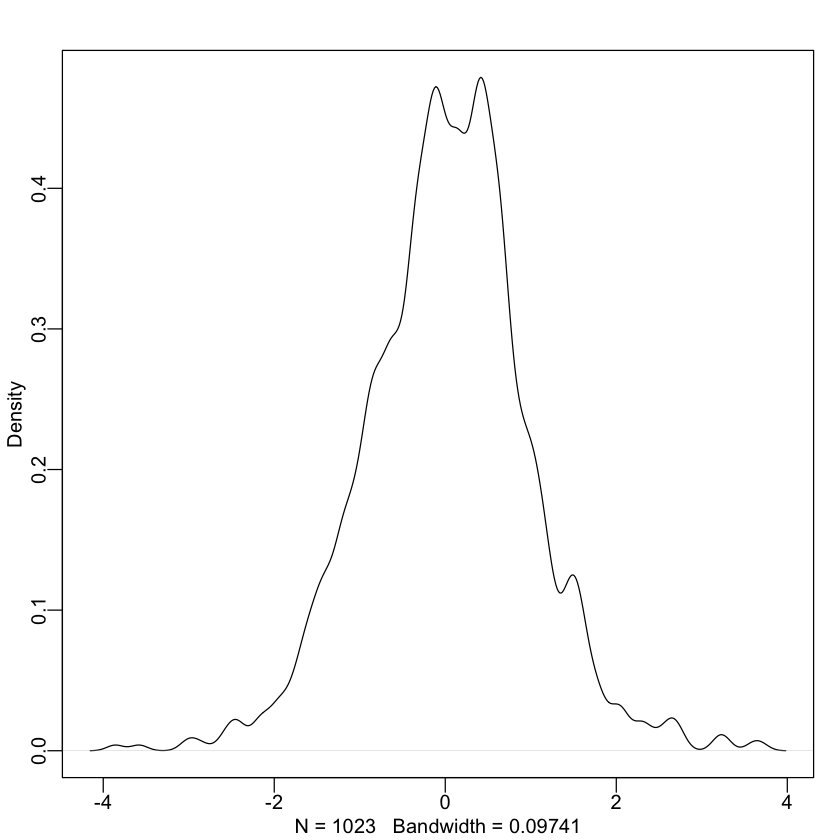

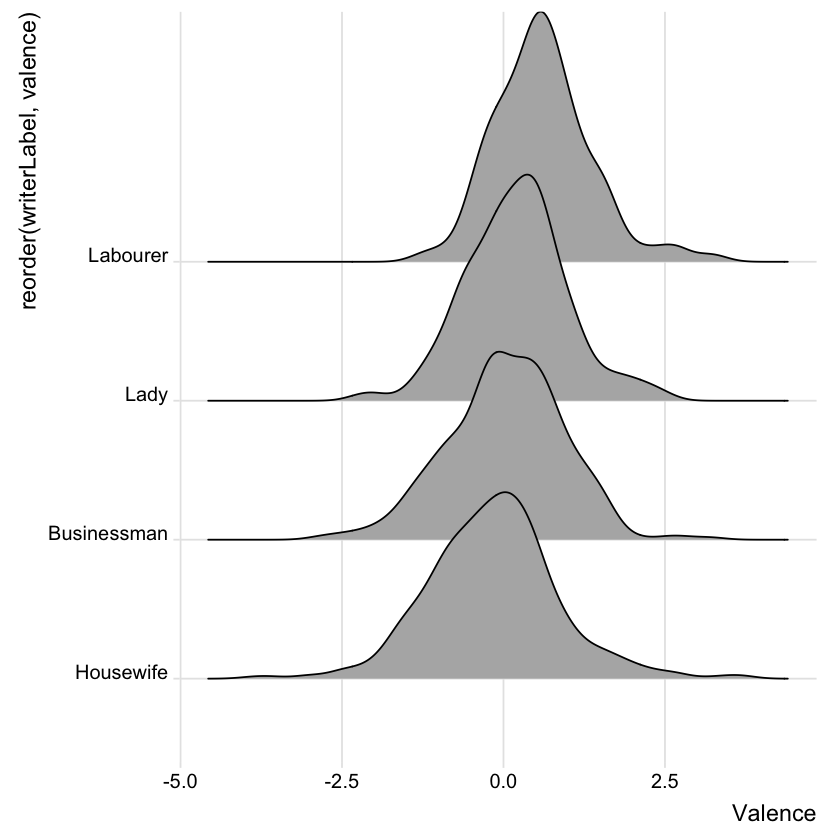

In [68]:
dens(df2$valence)

df2 %>% 
select(docid, valence) %>% 
group_by(docid) %>% 
summarize(min = min(valence),
          mean = mean(valence), 
          max = max(valence), 
          sd = sd(valence))

actualData <- df2 %>% 
select(docid, valence) 

actualData$writerLabel[actualData$docid=="D0002"] <- "Housewife"
actualData$writerLabel[actualData$docid=="D0003"] <- "Labourer"
actualData$writerLabel[actualData$docid=="D0007"] <- "Businessman"
actualData$writerLabel[actualData$docid=="D0009"] <- "Lady"

ggplot(actualData, aes(x = valence, y = reorder(writerLabel, valence))) +
  geom_density_ridges() +
theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Valence") 

### Complete pooling

$$valence_i \sim \mathrm{Normal}(\mu_i, \sigma)$$ 
$$\mu = \alpha $$
$$\alpha \sim \mathrm{Normal}(0,1)$$
$$\sigma \sim \mathrm{Uniform}(0,1)$$

https://soci620.netlify.app/slides/soci620_18_nestedDataPartialPooling.pdf

In [38]:
# Now swtiching to the more efficient BRMS package.
# What priors are needed?
#get_prior(data=df2, family=gaussian, formula=valence ~ 1)

#f2cp <- brm(data=df2,
#           family=gaussian,
#           valence ~ 1,
#           prior=c(prior("normal(0,1)",class=Intercept), # alpha, interecept, average score for all students
#                   prior("uniform(0,1)",class="sigma", ub=1)), # sigma, global standard deviation
#          iter=2000,warmup = 1000,chains=4,cores=4, seed = 4,
#          file = "20241011_PhD_DiaChkSenBRMS_01")

#print(f2cp)

# Complete Pooling - BRMS
f2cp <- readRDS("20241011_PhD_DiaChkSenBRMS_01.rds") # Get it back
print(f2cp)
#posterior_summary(f2s)[1:2,]

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: valence ~ 1 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.03      0.03    -0.03     0.09 1.00     1990     2120

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.95      0.02     0.91     0.99 1.00     1846     1095

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


In [8]:
# First the rethinking model to ensure results are close
f1s <- readRDS("20241010_PhD_DiaChkSen_01.rds")
precis(f1s, prob=.90)

,mean,sd,5%,95%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,0.02926731,0.02974685,-0.0196619,0.07819651
sigma,0.95185539,0.02104341,0.9172421,0.98646872


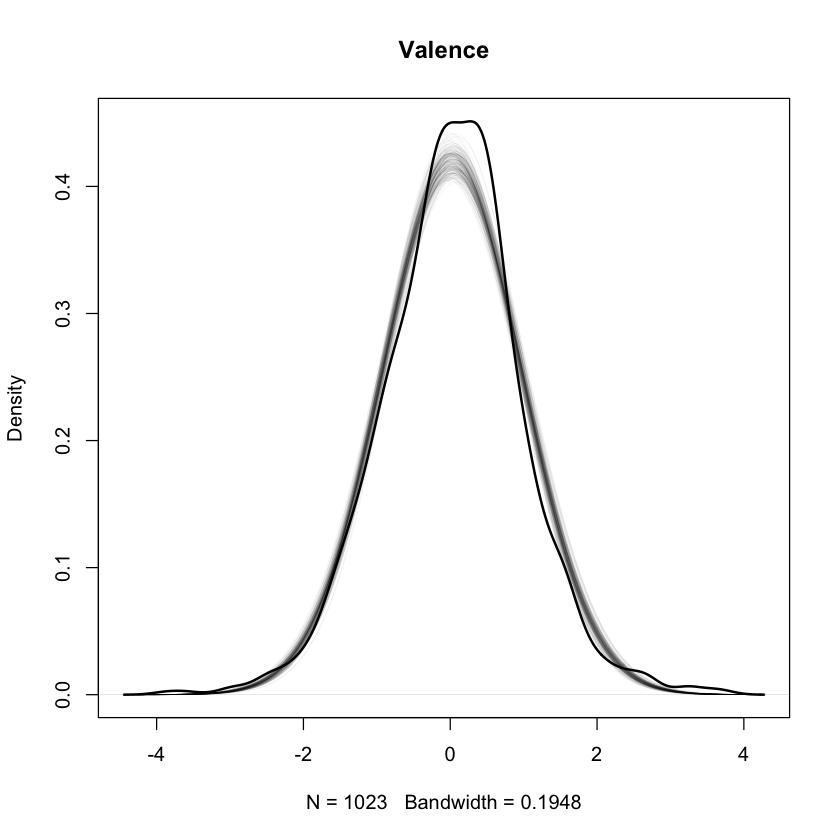

In [51]:
# draw 4000 samples from the joint posterior
coef_samp <- as_draws_df(f2cp)
# convert to dataframe
coef_samp <- as.data.frame(coef_samp)

# actual data
den <- density(df2$valence)
plot(den,lwd=2,,main="Valence")

# samples from the posterior
for(i in 1:200){
    y_fit <- dnorm(den$x,coef_samp[i,1],coef_samp[i,2])
    lines(den$x,y_fit,lwd=.5,col='#00000010')    
}


Picking joint bandwidth of 0.00524



,Estimate,Est.Error,Q2.5,Q97.5
Intercept,0.03049548,0.03069042,-0.03103307,0.0901492


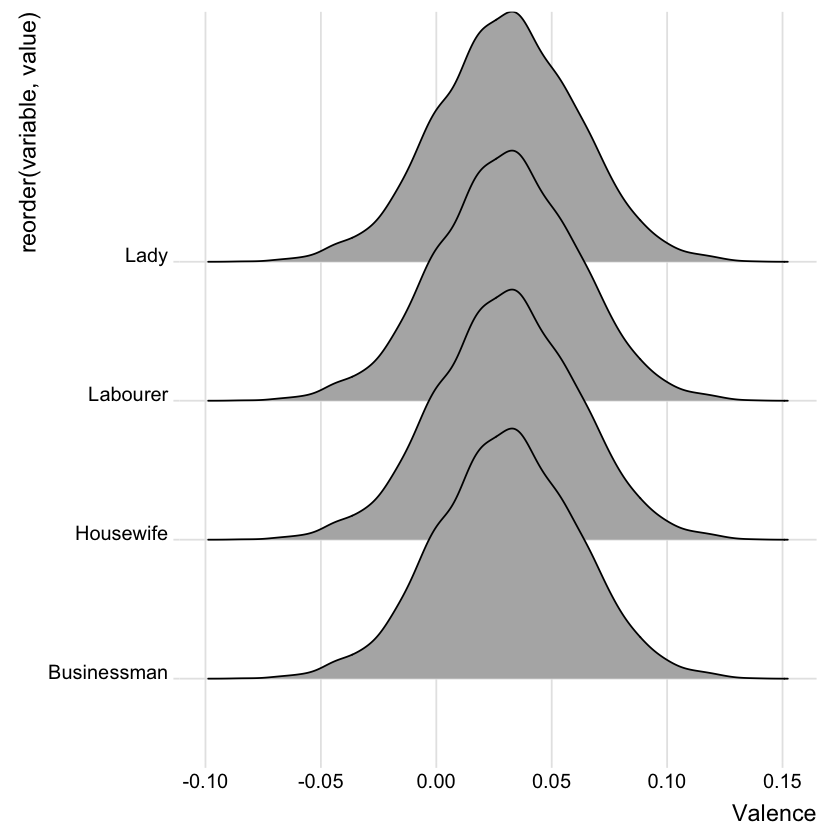

In [48]:
f <- data.frame(fitted(f2cp,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))
colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

f <- f %>%                                   
  gather(variable, value)

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() +
  theme(legend.position = "none") + 
xlab("Valence") 

fixef(f2cp)

### No pooling

Authorship can be accounted for in single level models in two ways. One is with indicator (i.e., "dummy") variables representing k - 1 categories (i.e., authors). The missing author (in this case the housewife) is the reference case that all others are compared to. First, I need to create the indicator variables for all authors except the housewife.

In [30]:
table(df2$docauthorid)

# housewife is the reference category

df2$housewife <- 0
df2$housewife[df2$docauthorid=="D0002"] <- 1

df2$labourer <- 0
df2$labourer[df2$docauthorid=="D0003"] <- 1

df2$businessman <- 0
df2$businessman[df2$docauthorid=="D0007"] <- 1

df2$lady <- 0
df2$lady[df2$docauthorid=="D0009"] <- 1

vars <- c("housewife", "labourer", "businessman", "lady")
df2 %>% select(all_of(vars)) %>%  colSums()


D0002 D0003 D0007 D0009 
  447   102   323   151 

housewife    labourer businessman        lady 
        447         102         323         151

Here is the notation.

$$sentiment_{i} \sim Normal(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha + \beta_1Labourer_i + \beta_2Businessman_i + \beta_3Lady_i $$
$$\alpha, \beta_1, \beta_2, \beta_3, \sim Normal(0, 1)$$ 
$$\sigma \sim Uniform(0,1)$$

<p>For notation, see https://soci620.netlify.app/slides/soci620_18_nestedDataPartialPooling.pdf (slide 10) and https://soci620.netlify.app/slides/soci620_06_covariates.pdf (slide 2).

In [31]:
# These are the kinds of priors I need.
#get_prior(data=df2,family=gaussian, formula = valence ~ 1 + labourer + businessman + lady)

f3npD <- readRDS("20241011_PhD_DiaChkSenBRMS-authors_01.rds")
print(f3npD)

# No pooling indicator approach

#f3npD <- brm(data=df2,
#           family=gaussian,
#           valence ~ 1 + labourer + businessman + lady,
#           prior=c(prior("normal(0,1)",class="Intercept"), # Housewife
#                   prior("normal(0,1)",class="b"),
#                   prior("uniform(0,1)",class="sigma", ub=1)),
#           iter=2000,warmup = 1000,chains=4,cores=4, seed = 4,
#           file = "20241011_PhD_DiaChkSenBRMS-authors_01")

#print(f3npD)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: valence ~ 1 + labourer + businessman + lady 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Regression Coefficients:
            Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept      -0.16      0.04    -0.24    -0.07 1.00     3870     2729
labourer        0.76      0.10     0.56     0.96 1.00     4375     3210
businessman     0.19      0.07     0.06     0.32 1.00     4079     3198
lady            0.36      0.09     0.18     0.52 1.00     4306     3226

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.93      0.02     0.89     0.97 1.00     3640     1588

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split c

Picking joint bandwidth of 0.0111



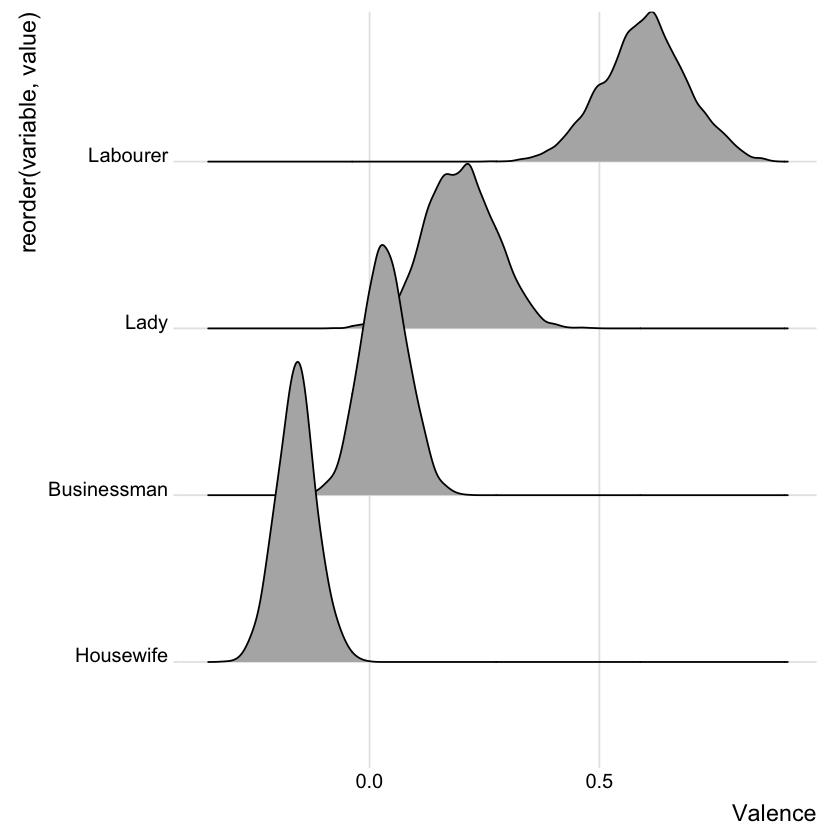

In [32]:
# Means

nd <- data.frame(
    labourer = c(0,1,0,0), 
    businessman = c(0,0,1,0),
    lady = c(0,0,0,1)
)

f <- data.frame(fitted(f3npD,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

f <- f %>%                                   
  gather(variable, value)

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() +
  theme(legend.position = "none") + 
xlab("Valence") 

In [34]:
# equivalent output to f3npD
#get_prior(data=df2, family=gaussian, formula=valence ~ 1 + docauthorid) # ref case is the housewife

#f4ccI <- readRDS("20241011_PhD_DiaChkSenBRMS-authorsI_01.rds")
#print(f4ccI)

#f4ccI <- brm(data=df2,
#           family=gaussian,
#           valence ~ 1 + docauthorid,
#           prior=c(prior("normal(0,1)",class="Intercept"),
#                   prior("normal(0,1)",class="b"),
#                   prior("uniform(0,1)",class="sigma", ub=1)),
#           iter=2000,warmup = 1000,chains=4,cores=4, seed = 4,
#           file = "20241011_PhD_DiaChkSenBRMS-authorsI_01")

#print(f4ccI)

<p>A similar approach can be achieved by using a fixed effects model with an index variable, as described <a href="https://bookdown.org/content/4857/the-many-variables-the-spurious-waffles.html#many-categories">here</a> (section 5.3.2, model b5.9) and <a href="https://soci620.netlify.app/slides/soci620_18_nestedDataPartialPooling.pdf">here</a> (slide 10). Each group gets its own independent intercept (i.e., no global mean).</p>

$$sentiment_{i} \sim Normal(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha_{docauthorid[i]}$$
$$\alpha_j \sim Normal(0, 1) \quad for j = 1,…,4$$ 
$$\sigma \sim Uniform(0,1)$$


$$sentiment_{ik} \sim Normal(\mu_{ik}, \sigma)$$
$$\mu_{ik} = \alpha_k*$$ 
$$\alpha_k \sim Normal(0,1)$$ 
$$\sigma \sim Uniform(0,1)$$ 

<ul>
    <li>* Each writer has its own independent intercept</li>
    <li>See specification b5.9 in Kurz (2023, Version 0.4.0).</li>
    <li>See https://soci620.netlify.app/slides/soci620_18_nestedDataPartialPooling.pdf
    <li>McElreath(2020, Section 13.2.4. and p. 414)</li>
</ul>

In [35]:
#get_prior(data=df2, family=gaussian, valence ~ 0 + docauthorid)

f4npI <- readRDS("20241011_PhD_DiaChkSen_munp.rds")
print(f4npI)

# No pooling index / fixed effects approach
#f4npI <- brm(data=df2,
#            family = 'gaussian',
#           formula= valence ~ 0 + docauthorid, # **
#            prior=c(set_prior("normal(0,1)",class="b"),
#                   set_prior("uniform(0,1)",class="sigma", ub = 1)),
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20241011_PhD_DiaChkSen_munp",
#            control=list(adapt_delta=.99))
#print(f4npI)

# See Kurz (2023, version 0.4.0, Section 13.2.4 and Model b5.8) for specification 
## This can also be achieved using -1 + notation described in https://soci620.netlify.app/labs/lab_17.Rmd
### See pg 14
#### See also b13.1

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: valence ~ 0 + docauthorid 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Regression Coefficients:
                 Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
docauthoridD0002    -0.16      0.04    -0.25    -0.07 1.00     4000     2542
docauthoridD0003     0.60      0.09     0.42     0.78 1.00     4181     2570
docauthoridD0007     0.03      0.05    -0.07     0.13 1.00     4149     2556
docauthoridD0009     0.20      0.07     0.05     0.34 1.00     4281     2739

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.93      0.02     0.89     0.97 1.00     3593     2033

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on 

Picking joint bandwidth of 0.0111



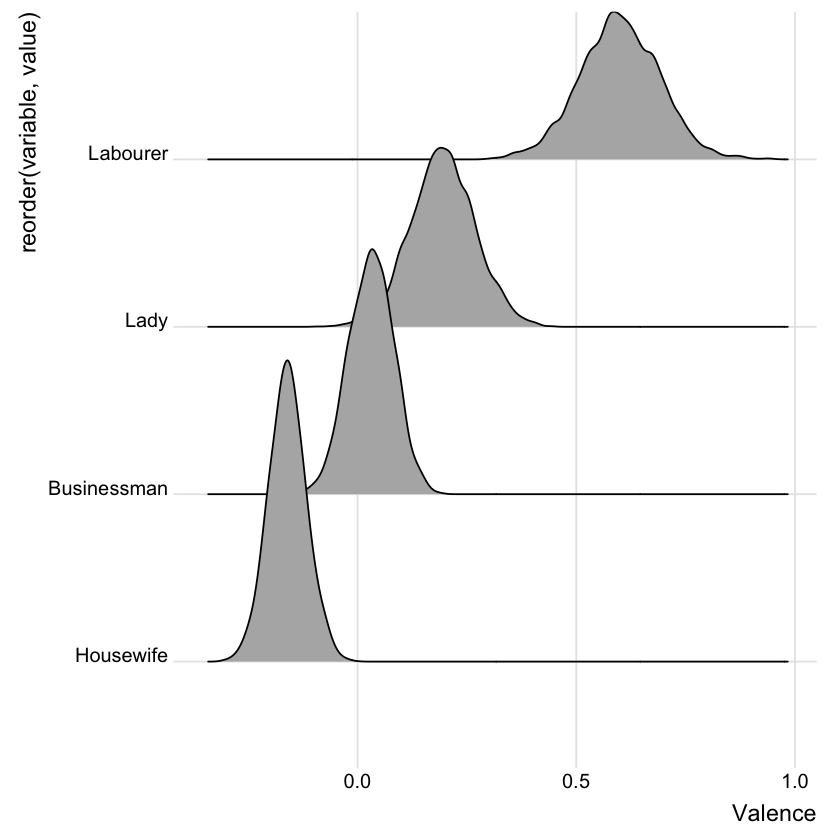

In [38]:
# Means

nd <- distinct(df2, docauthorid)

f <- data.frame(fitted(f4npI,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

f <- f %>%                                   
  gather(variable, value)

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() +
  theme(legend.position = "none") + 
xlab("Valence") 

In [27]:
# equivalent output to f4npI
#f7npIb <- readRDS("20241011_PhD_DiaChkSen_munpComp.rds")
#print(f7npIb)

## Just checking to make sure 0 and -1 are truly interchangeable.
## See lab_18

#f7npIb <- brm(data=df2,
#            family = 'gaussian',
#           formula= valence ~ -1 + docauthorid, # **
#            prior=c(set_prior("normal(0,1)",class="b"),
#                   set_prior("uniform(0,1)",class="sigma", ub = 1)),
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20241011_PhD_DiaChkSen_munpComp",
#            control=list(adapt_delta=.99))
#print(f7npIb)

In [34]:
# equivalent output to f4npI
# get_prior(data=df2, family=gaussian, valence ~ 0 + housewife + labourer + businessman + lady)

#f8npD <- readRDS("20241011_PhD_DiaChkSen_munpCompI.rds")
#print(f8npD)

#f8npD <- brm(data=df2,
#            family = 'gaussian',
#           formula= valence ~ 0 + housewife + labourer + businessman + lady, # **
#            prior=c(set_prior("normal(0,1)",class="b"),
#                   set_prior("uniform(0,1)",class="sigma", ub = 1)),
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20241011_PhD_DiaChkSen_munpCompI",
#            control=list(adapt_delta=.99))
#print(f8npD)

### Partial Pooling

<p>The other way to model clusters is with "partial pooling" (random effects)</p>

$$sentiment_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$
$$\mu_{ik} = \alpha_k$$
$$\alpha_k \sim \mathrm{Normal}(\gamma, \phi)* $$ 
$$\gamma \sim \mathrm{Normal}(0,1)* $$ 
$$\phi \sim \mathrm{Uniform}(0,1)* $$
$$\sigma \sim \mathrm{Uniform}(0,1)**$$ 

<ul>
    <li>* Typical writer (fixed)</li>
    <li>** Variability for each writer (random).</li>
</ul>

<p>For general notation, see https://soci620.netlify.app/slides/soci620_19_randomIntercepts.pdf and https://soci620.netlify.app/slides/soci620_18_nestedDataPartialPooling.pdf (slide 11), noting that $\phi$ and $\eta$ are used in the different examples to represent sd (variability between all classrooms). I used $\phi$ here.

In [6]:
#get_prior(data=df2, family=gaussian, valence ~ 1 + (1 | docauthorid))

f5pp <- readRDS("20241011_PhD_DiaChkSen_pp.rds")
print(f5pp)

#f5pp <- brm(data=df2,
#            family = 'gaussian',
#            formula = valence ~ 1 + (1 | docauthorid),
#            prior=c(set_prior("normal(0,1)",class="Intercept"), # gamma
#                    set_prior("uniform(0,1)",class="sd", ub=1), #phi
#                    set_prior("uniform(0,1)",class="sigma", ub=1)), #sigma
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20241011_PhD_DiaChkSen_pp.rds",
#            control=list(adapt_delta=.99))
#print(f5pp)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: valence ~ 1 + (1 | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.46      0.20     0.18     0.91 1.00      943     1148

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.15      0.23    -0.36     0.62 1.00      770      746

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.93      0.02     0.89     0.97 1.00     1815     1327

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergen

Picking joint bandwidth of 0.0113

Saving 7 x 7 in image
Picking joint bandwidth of 0.0113



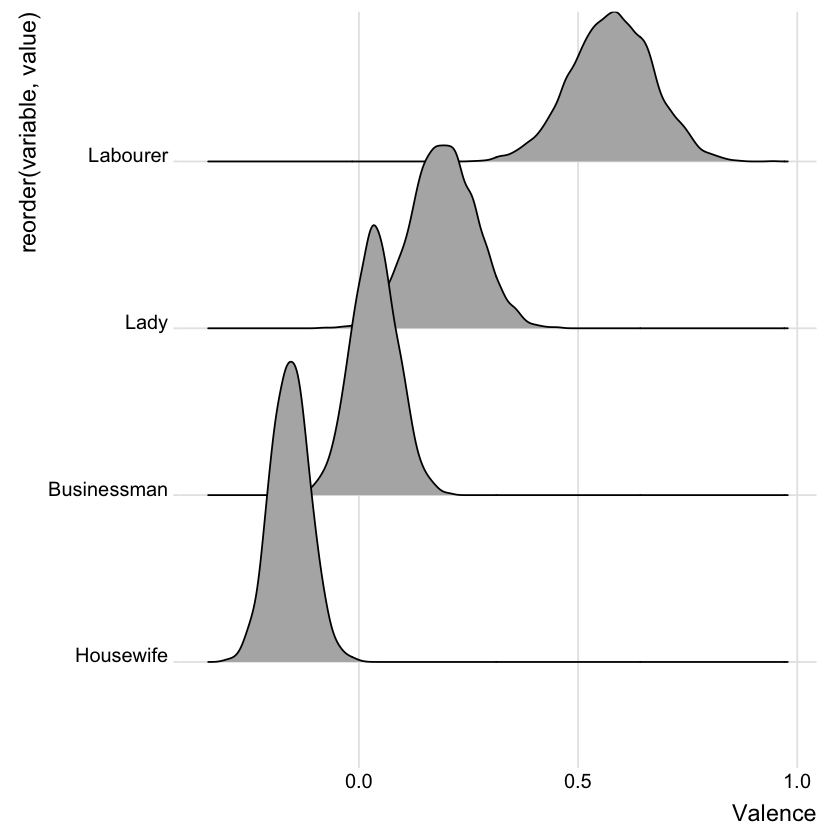

In [7]:
# Means

nd <- distinct(df2, docauthorid)

f <- data.frame(fitted(f5pp,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

f <- f %>%                                   
  gather(variable, value)

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() +
  theme(legend.position = "none") + 
xlab("Valence") 

ggsave("20241011_val_pp-randomMeans.jpg")

In [37]:
# Random + Fixed Estimates

# Way 1
post_mdn <- 
  coef(f5pp, robust = T)$docauthorid[, , ] %>% 
  data.frame()

head(post_mdn)

#Way 2
fe <- fixef(f5pp, probs = c(0.05, 0.95))
fe

re <- ranef(f5pp, probs = c(0.05, 0.95))
str(re)
re$docauthorid[,,"Intercept"]

fe[1,1] + re$docauthorid[,,"Intercept"][1,1] #Housewife
fe[1,1] + re$docauthorid[,,"Intercept"][2,1] #Labourer
fe[1,1] + re$docauthorid[,,"Intercept"][3,1] #Businessman
fe[1,1] + re$docauthorid[,,"Intercept"][4,1] #Lady

,Estimate,Est.Error,Q2.5,Q97.5
,<dbl>,<dbl>,<dbl>,<dbl>
D0002,-0.15728297,0.04482598,-0.24484825,-0.06937654
D0003,0.57822243,0.09440116,0.39012713,0.75592921
D0007,0.03478862,0.05173824,-0.06693668,0.13809148
D0009,0.19362551,0.07504968,0.04926109,0.34127037


,Estimate,Est.Error,Q5,Q95
Intercept,0.1511647,0.2347234,-0.2346829,0.531693


List of 1
 $ docauthorid: num [1:4, 1:4, 1] -0.308 0.426 -0.116 0.043 0.237 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:4] "D0002" "D0003" "D0007" "D0009"
  .. ..$ : chr [1:4] "Estimate" "Est.Error" "Q5" "Q95"
  .. ..$ : chr "Intercept"


,Estimate,Est.Error,Q5,Q95
D0002,-0.30789852,0.2365686,-0.68838938,0.08126191
D0003,0.42580857,0.2474945,0.04462738,0.85239829
D0007,-0.11601453,0.2379310,-0.49737358,0.28193246
D0009,0.04298031,0.2409305,-0.34025717,0.44566021


[1] -0.1567338

[1] 0.5769733

[1] 0.03515019

[1] 0.194145

#### Model Comparison

In [66]:
# Compare Models
f2cp_i <- add_criterion(f2cp, "waic")
f3npD_i <- add_criterion(f3npD, "waic")
f4npI_i <- add_criterion(f4npI, "waic")
f5pp_i <- add_criterion(f5pp, "waic")
#f6npIa_i <- add_criterion(f6npIa, "waic") 
#f7npIb_i <- add_criterion(f7npIb, "waic")
#f8npD_i <- add_criterion(f8npD, "waic")

w <- loo_compare(f2cp_i, f3npD_i, f4npI_i, f5pp_i, criterion = "waic")

print(w, simplify = F)

Automatically saving the model object in '20241011_PhD_DiaChkSen_pp.rds'



        elpd_diff se_diff elpd_waic se_elpd_waic p_waic  se_p_waic waic   
f4npI_i     0.0       0.0 -1375.3      28.9          5.0     0.4    2750.6
f3npD_i    -0.2       0.1 -1375.4      28.9          5.2     0.4    2750.9
f5pp_i     -0.3       0.2 -1375.5      28.9          5.2     0.4    2751.1
f2cp_i    -28.0       7.2 -1403.3      28.1          2.4     0.3    2806.6
        se_waic
f4npI_i    57.7
f3npD_i    57.7
f5pp_i     57.7
f2cp_i     56.1


In [49]:
glimpse(df2)

Rows: 1,023
Columns: 47
$ docid            <fct> D0002, D0002, D0002, D0002, D0002, D0002, D0002, D000…
$ docyear          <int> 1883, 1883, 1883, 1883, 1883, 1883, 1883, 1883, 1883,…
$ docmonth         <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ authorName       <fct> Anne F. Richards, Anne F. Richards, Anne F. Richards,…
$ docauthorid      <fct> D0002, D0002, D0002, D0002, D0002, D0002, D0002, D000…
$ authorLocation   <fct> Australia, Australia, Australia, Australia, Australia…
$ authorGender     <fct> F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F,…
$ nationalOrigin   <fct> English, English, English, English, English, English,…
$ irish            <fct> False, False, False, False, False, False, False, Fals…
$ otherUK          <fct> True, True, True, True, True, True, True, True, True,…
$ relMin           <fct> False, False, False, False, False, False, False, Fals…
$ catholic         <fct> False, False, False, False, False, False, False, Fals…
$ otherChristian

In [54]:
write.csv(df2, "20241011_PhD_DiaChk-RQ1b.csv", row.names=FALSE)